In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import zscore
import scipy.stats as stats
from scipy.stats import chi2_contingency
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc
from mlxtend.evaluate import permutation_test
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

In [2]:
data = pd.read_csv('./data/application_train_vf.csv')
bureau = pd.read_csv('./data/bureau.csv')
data.shape

(306107, 124)

# Rapide dataviz de bureau

In [3]:
data.shape

(306107, 124)

variable à garder pour tester : 'AMT_CREDIT_SUM_OVERDUE', 'CREDIT_TYPE', 'DAYS_CREDIT_UPDATE', 'CNT_CREDIT_PROLONG', 'CREDIT_CURRENCY', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT'

In [4]:
bureau_temporaire = bureau[['SK_ID_CURR','AMT_CREDIT_SUM_OVERDUE', 'CREDIT_TYPE', 'DAYS_CREDIT_UPDATE', 'CNT_CREDIT_PROLONG', 'CREDIT_CURRENCY', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT']]

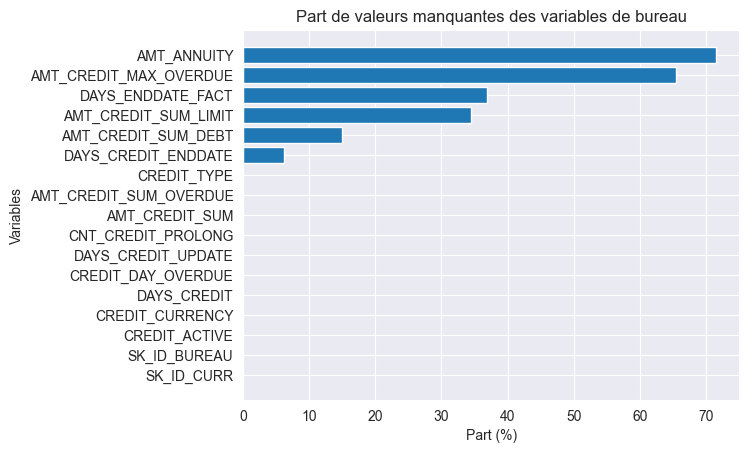

In [5]:
missing_values = round((bureau.isna().sum()/bureau.shape[0])*100,2)

missing_values = missing_values.sort_values(ascending=True)

plt.barh(missing_values.index, missing_values.values)

plt.xlabel('Part (%)')
plt.ylabel('Variables')
plt.title('Part de valeurs manquantes des variables de bureau')

plt.show()

# Data treatment bureau

on doit avoir une ligne par SK_ID_CURR donc on va prendre le mode par SK_ID et la mediane de chaque var qu'on a selectionner pour reduire les lignes

In [6]:
numerical_columns = bureau_temporaire.drop(columns = 'SK_ID_CURR').select_dtypes(include='number').columns
categorical_columns = bureau_temporaire.select_dtypes(include='object').columns

new_df = pd.DataFrame()

for col in numerical_columns:
    new_df[col] = bureau_temporaire.groupby('SK_ID_CURR')[col].mean()


for col in categorical_columns:
    new_df[col] = bureau_temporaire.groupby('SK_ID_CURR')[col].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)


new_df.reset_index(inplace=True)


In [7]:
new_df

,SK_ID_CURR,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,CNT_CREDIT_PROLONG,CREDIT_DAY_OVERDUE,DAYS_CREDIT,CREDIT_TYPE,CREDIT_CURRENCY
0,100001,0.0,-93.142857,0.000000,0.0,-735.000000,Consumer credit,currency 1
1,100002,0.0,-499.875000,0.000000,0.0,-874.000000,Consumer credit,currency 1
2,100003,0.0,-816.000000,0.000000,0.0,-1400.750000,Consumer credit,currency 1
3,100004,0.0,-532.000000,0.000000,0.0,-867.000000,Consumer credit,currency 1
4,100005,0.0,-54.333333,0.000000,0.0,-190.666667,Consumer credit,currency 1
...,...,...,...,...,...,...,...,...
305806,456249,0.0,-1064.538462,0.000000,0.0,-1667.076923,Consumer credit,currency 1
305807,456250,0.0,-60.333333,0.000000,0.0,-862.000000,Consumer credit,currency 1
305808,456253,0.0,-253.250000,0.000000,0.0,-867.500000,Consumer credit,currency 1
305809,456254,0.0,-401.000000,0.000000,0.0,-1104.000000,Consumer credit,currency 1


### Encoding

In [8]:
new_df.select_dtypes(include='object').nunique()

CREDIT_TYPE        12
CREDIT_CURRENCY     3
dtype: int64

Peu de modalités on va donc OHE

In [9]:
cat_col_bureau = new_df.select_dtypes(include='object').columns

new_df = pd.get_dummies(new_df, columns=cat_col_bureau, dtype='int',drop_first=True)

In [10]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305811 entries, 0 to 305810
Data columns (total 19 columns):
 #   Column                                              Non-Null Count   Dtype  
---  ------                                              --------------   -----  
 0   SK_ID_CURR                                          305811 non-null  int64  
 1   AMT_CREDIT_SUM_OVERDUE                              305811 non-null  float64
 2   DAYS_CREDIT_UPDATE                                  305811 non-null  float64
 3   CNT_CREDIT_PROLONG                                  305811 non-null  float64
 4   CREDIT_DAY_OVERDUE                                  305811 non-null  float64
 5   DAYS_CREDIT                                         305811 non-null  float64
 6   CREDIT_TYPE_Car loan                                305811 non-null  int32  
 7   CREDIT_TYPE_Cash loan (non-earmarked)               305811 non-null  int32  
 8   CREDIT_TYPE_Consumer credit                         305811 non-n

# Data treatment de data

In [11]:
data.drop(columns = 'Unnamed: 0',inplace = True)

In [12]:
data = data[['SK_ID_CURR','TARGET', 'DAYS_BIRTH', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'EXT_SOURCE_1',
       'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_LAST_PHONE_CHANGE']]

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306107 entries, 0 to 306106
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   306107 non-null  int64  
 1   TARGET                       306107 non-null  int64  
 2   DAYS_BIRTH                   306107 non-null  int64  
 3   DAYS_ID_PUBLISH              306107 non-null  int64  
 4   OWN_CAR_AGE                  104145 non-null  float64
 5   REGION_RATING_CLIENT         306107 non-null  int64  
 6   REGION_RATING_CLIENT_W_CITY  306107 non-null  int64  
 7   EXT_SOURCE_1                 133543 non-null  float64
 8   EXT_SOURCE_2                 305451 non-null  float64
 9   EXT_SOURCE_3                 245467 non-null  float64
 10  DAYS_LAST_PHONE_CHANGE       306106 non-null  float64
dtypes: float64(5), int64(6)
memory usage: 25.7 MB


In [14]:
data.drop(columns =['OWN_CAR_AGE','EXT_SOURCE_1','EXT_SOURCE_3'],inplace = True)

In [15]:
data.dropna(inplace = True)

### Encoding

In [16]:
impact_dicts = {}
categorical_columns = data.select_dtypes(include = 'object')

for categorical_feature in data.select_dtypes(include = 'object').columns :#['ORGANIZATION_TYPE'] :

    category_means = data.groupby(categorical_feature)['TARGET'].mean()
    category_impacts = category_means - category_means.mean()

    impact_dicts[categorical_feature] = category_impacts.to_dict()

    data['encoded_' + categorical_feature] = data[categorical_feature].map(impact_dicts[categorical_feature])
    data.drop(columns= categorical_feature, inplace=True)   

# Merging Data + Bureau

In [17]:
df = data.merge(new_df, on = 'SK_ID_CURR')

In [18]:
df.drop(columns = ['CREDIT_TYPE_Cash loan (non-earmarked)'], inplace = True)

# Modelisation

In [19]:
X = df.drop(columns = ['SK_ID_CURR','TARGET'], axis=1)
y = df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=889)

In [20]:
import statsmodels.api as sm

X_train_scaled = sm.add_constant(X_train)

model = sm.Logit(y_train, X_train)
result = model.fit_regularized(method='l1')

# Affichage des résultats
print(result.summary())


C:\Users\baheu\Documents\M2 MoSEF\Challenge Nexialog\venv\lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\baheu\Documents\M2 MoSEF\Challenge Nexialog\venv\lib\site-packages\statsmodels\discrete\discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.24750180016751488
            Iterations: 132
            Function evaluations: 173
            Gradient evaluations: 132
                           Logit Regression Results                           
Dep. Variable:                 TARGET   No. Observations:               209460
Model:                          Logit   Df Residuals:                   209437
Method:                           MLE   Df Model:                           22
Date:                Wed, 17 Jan 2024   Pseudo R-squ.:                 0.05757
Time:                        19:31:09   Log-Likelihood:                -51842.
converged:                       True   LL-Null:                       -55008.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                         coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------

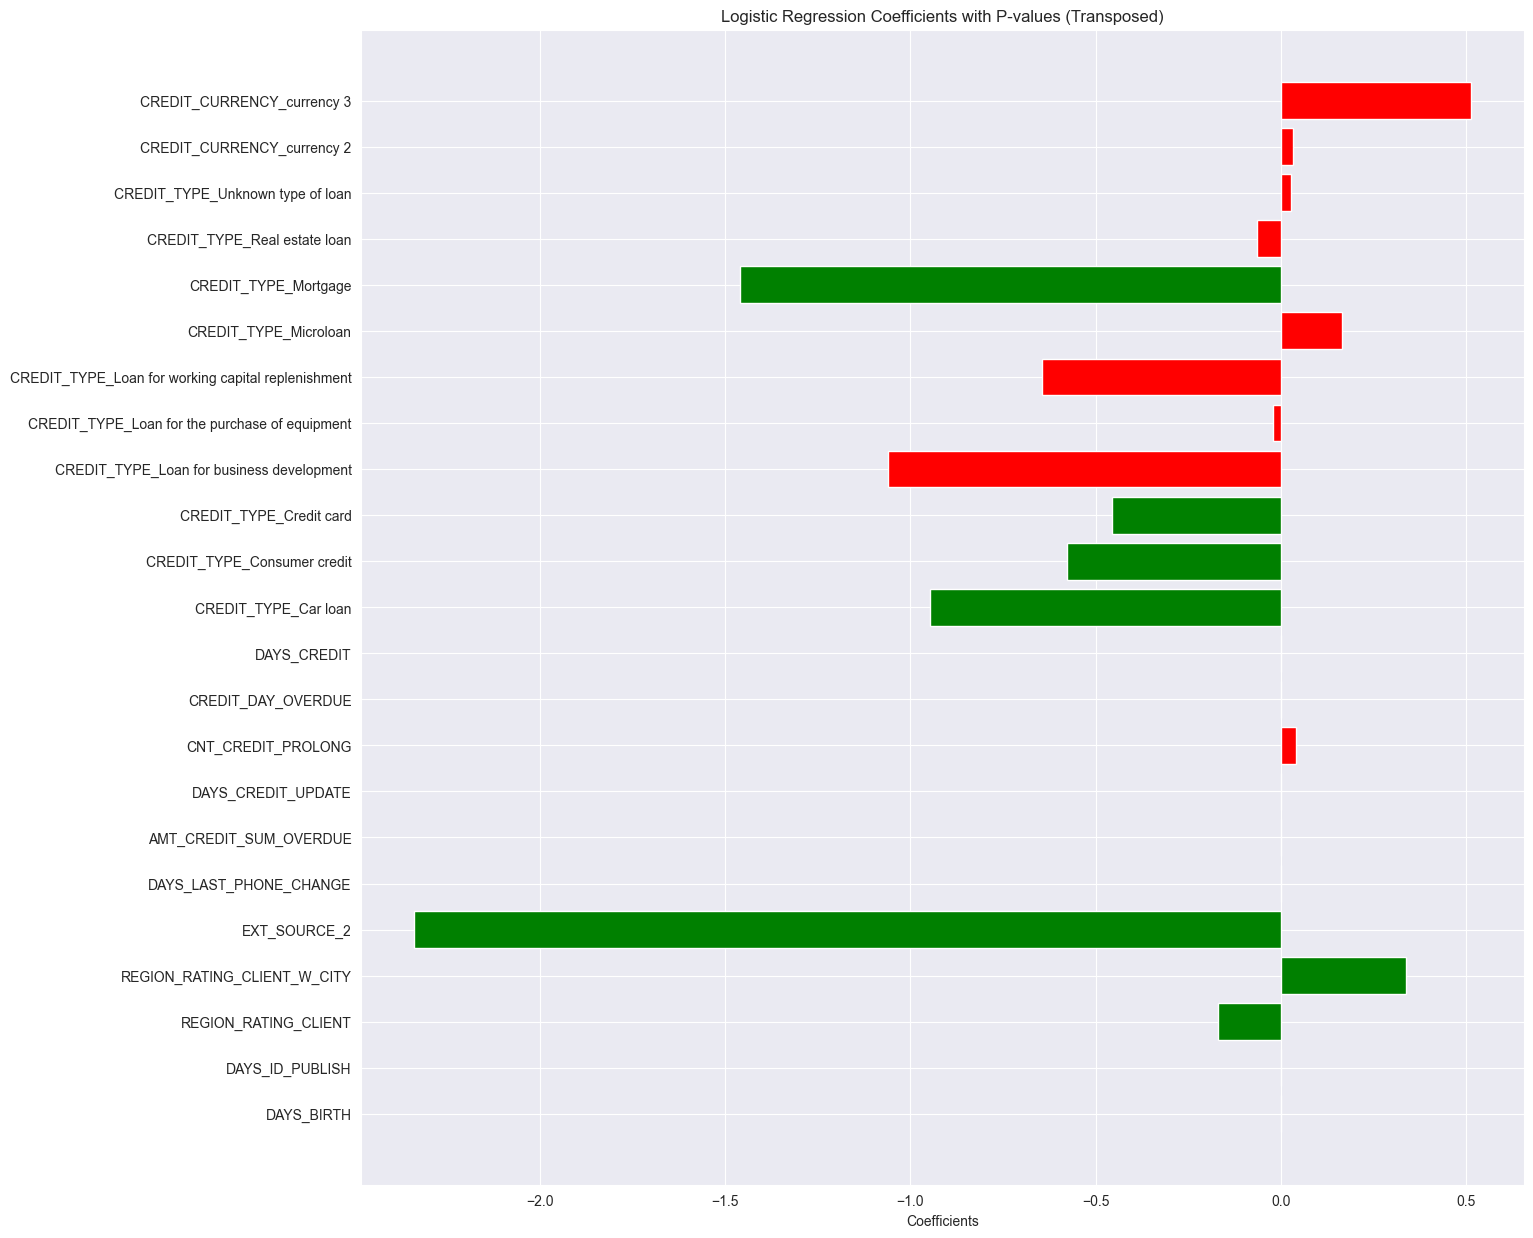

In [21]:
coefficients = result.params
pvalues = result.pvalues

var_signif = [variable for variable, p_value in zip(X.columns, pvalues) if p_value < 0.05]

# Plot des coefficients avec des couleurs différentes en fonction des p-values (transposé)
colors = ['red' if p > 0.05 else 'green' for p in pvalues]

plt.figure(figsize=(15, 15))
plt.barh(range(len(coefficients)), coefficients, color=colors)
plt.yticks(range(len(coefficients)), X.columns)
plt.xlabel('Coefficients')
plt.title('Logistic Regression Coefficients with P-values (Transposed)')
plt.show()

# Resultats

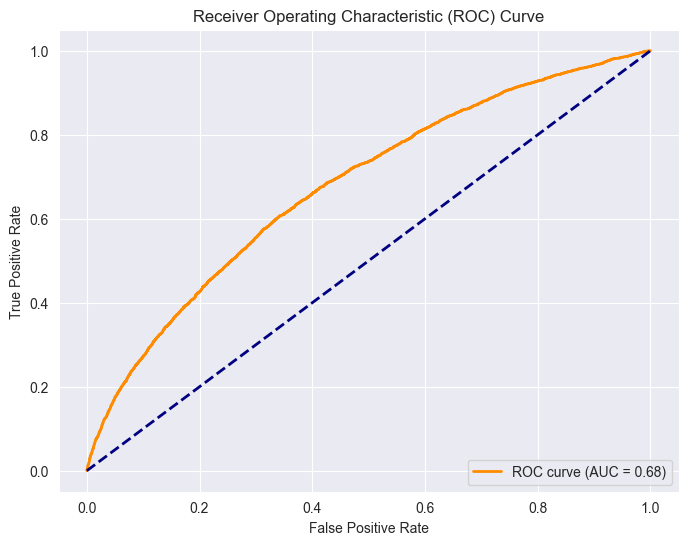

In [22]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

X_test_scaled = sm.add_constant(X_test)


y_prob = result.predict(X_test)


fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()